In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tqdm 
from collections import defaultdict

from itertools import combinations

In [3]:
df = pd.read_csv('outputs/analysis_lists/all_analysis_week_12.csv')
reg = pd.read_csv('feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv', sep='\t')
call = pd.read_csv('feb16-mar15_data/call/older/call_data_week_1.csv', sep='\t')
interv_df = pd.read_csv('outputs/interventions.csv')
analysis_df = pd.read_csv('outputs/state-cluster-whittle-E_C.csv')

# Load transition prob and starting states


In [5]:
with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


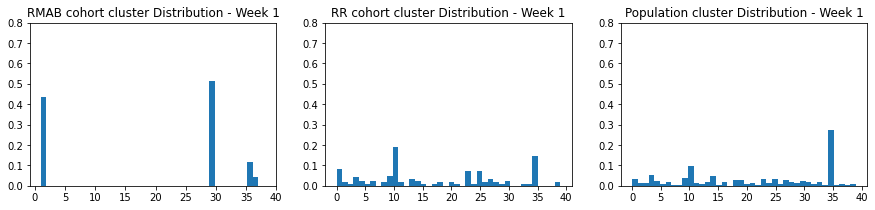

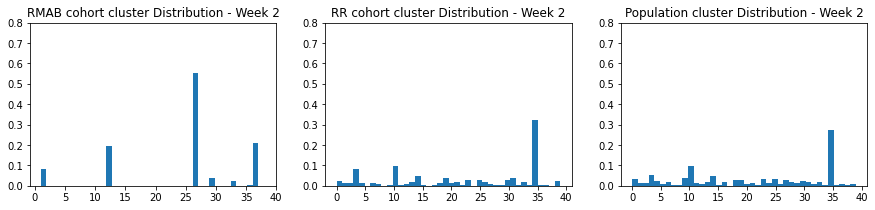

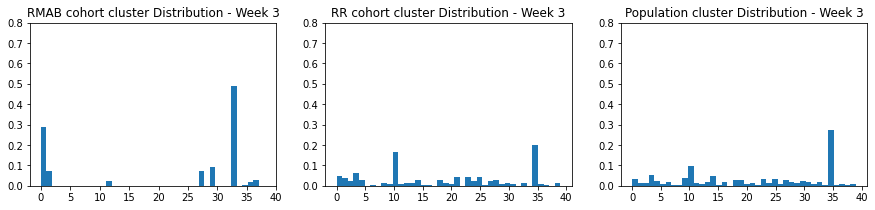

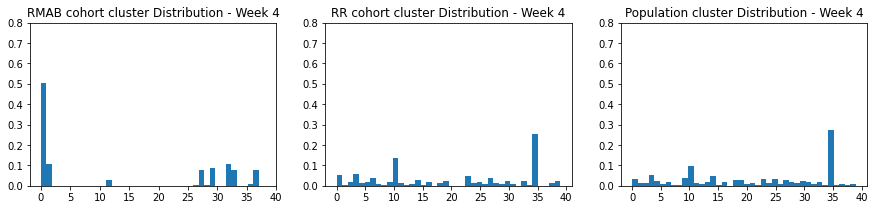

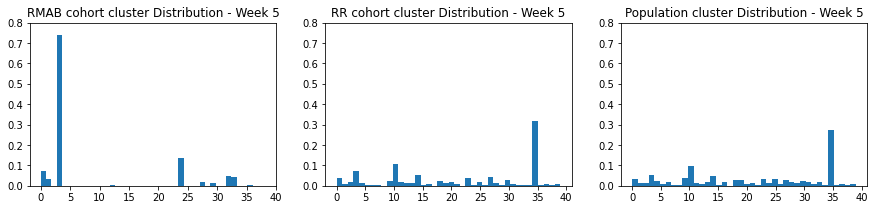

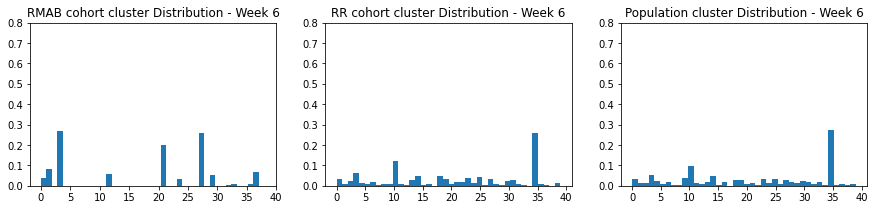

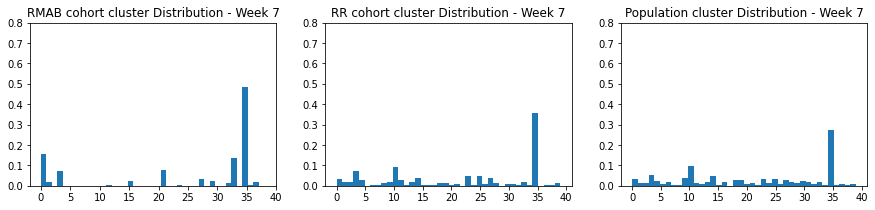

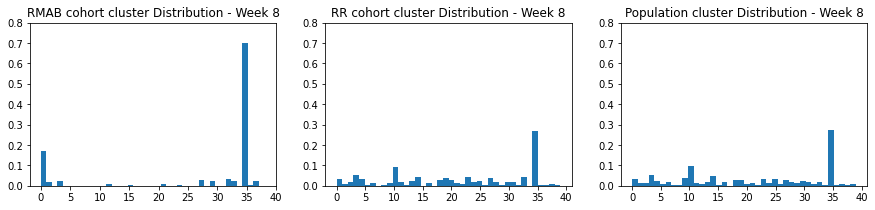

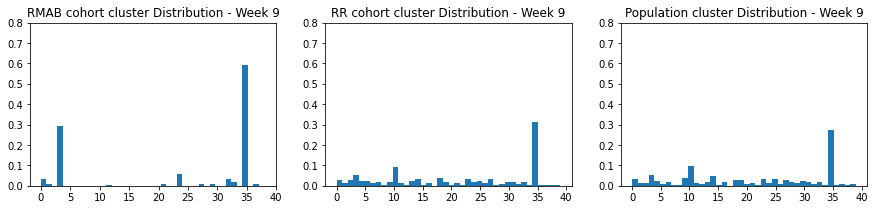

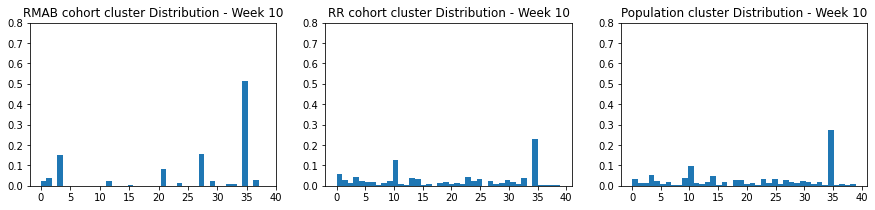

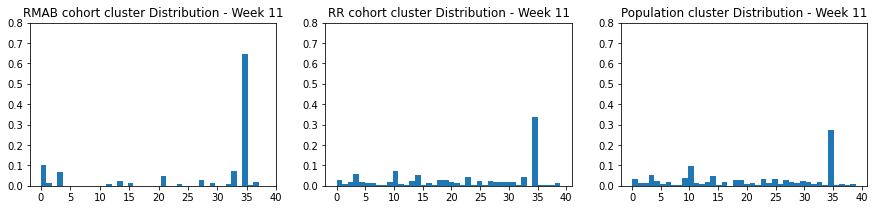

In [6]:
T = 12

for i in range(T-1):
    plt.figure(figsize=(15, 3))
    sub = interv_df[interv_df['intervene_week']==f'week{i+1}']
    plt.subplot(1,3,1)
    plt.hist(sub[sub['exp_group']=='rmab']['cluster'].values,density=True, bins=40)
    plt.ylim(0, 0.8)
    plt.xticks([5*(i) for i in range(9)],
          [str(5*(i)) for i in range(9)])
    plt.title(f'RMAB cohort cluster Distribution - Week {i+1}')
    plt.subplot(1,3,2)
    plt.hist(sub[sub['exp_group']=='round_robin']['cluster'].values, density=True, bins=40)
    plt.ylim(0, 0.8)
    plt.xticks([5*(i) for i in range(9)],
          [str(5*(i)) for i in range(9)])
    plt.title(f'RR cohort cluster Distribution - Week {i+1}')
    plt.subplot(1,3,3)
    plt.hist(analysis_df['cluster'].values, density=True, bins=40)
    plt.ylim(0, 0.8)
    plt.xticks([5*(i) for i in range(9)],
          [str(5*(i)) for i in range(9)])
    plt.title(f'Population cluster Distribution - Week {i+1}')

    

In [7]:
interv_df['intervene_week'].value_counts()

week10    1000
week9     1000
week8     1000
week11    1000
week7      700
week6      600
week5      435
week3      400
week4      400
week2      400
week1      250
Name: intervene_week, dtype: int64

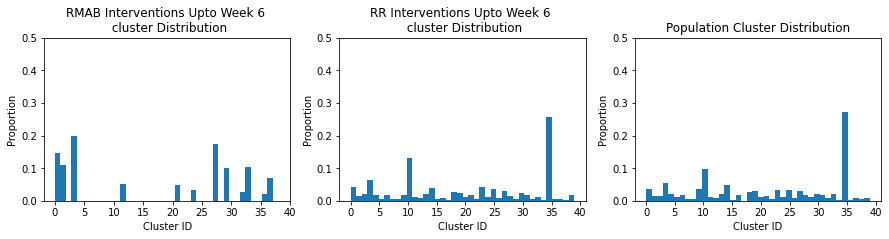

In [8]:
T = 12

upto_week = 6
week_list = [f'week{i+1}' for i in range(upto_week)]

plt.figure(figsize=(15, 3))
sub = interv_df[interv_df['intervene_week'].isin(week_list)]
plt.subplot(1,3,1)
plt.hist(sub[sub['exp_group']=='rmab']['cluster'].values,density=True, bins=40)
plt.ylim(0, 0.5)
plt.xticks([5*(i) for i in range(9)],
      [str(5*(i)) for i in range(9)])
plt.xlabel('Cluster ID')
plt.ylabel('Proportion')
plt.title(f'RMAB Interventions Upto Week {upto_week} \n cluster Distribution')
plt.subplot(1,3,2)
plt.hist(sub[sub['exp_group']=='round_robin']['cluster'].values, density=True, bins=40)
plt.ylim(0, 0.5)
plt.xticks([5*(i) for i in range(9)],
      [str(5*(i)) for i in range(9)])
plt.xlabel('Cluster ID')
plt.ylabel('Proportion')
plt.title(f'RR Interventions Upto Week {upto_week} \n cluster Distribution')
plt.subplot(1,3,3)
plt.hist(analysis_df['cluster'].values, density=True, bins=40)
plt.ylim(0, 0.5)
plt.xticks([5*(i) for i in range(9)],
      [str(5*(i)) for i in range(9)])
plt.xlabel('Cluster ID')
plt.ylabel('Proportion')
plt.title(f'Population Cluster Distribution')
plt.show()
    

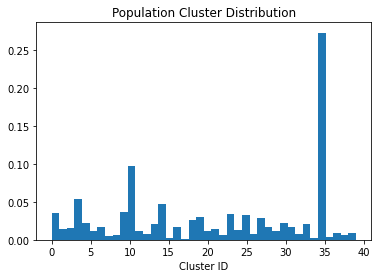

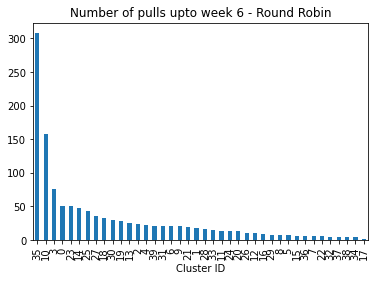

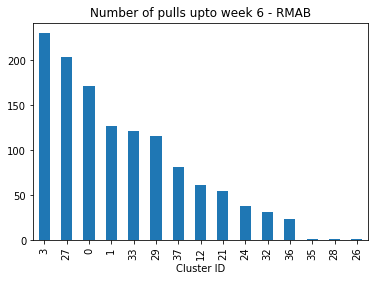

In [9]:
plt.hist(analysis_df['cluster'].values, density=True, bins=40)
plt.title('Population Cluster Distribution')
plt.xlabel('Cluster ID')
plt.show()

upto_week = 6
week_list = [f'week{i+1}' for i in range(upto_week)]

total_cluster_distr = interv_df[(interv_df['exp_group']=='round_robin') &
          (interv_df['intervene_week'].isin(week_list))]['cluster'].value_counts()

total_cluster_distr.plot(kind='bar')
plt.title(f'Number of pulls upto week {upto_week} - Round Robin')
plt.xlabel('Cluster ID')
plt.show()


total_cluster_distr = interv_df[(interv_df['exp_group']=='rmab') &
          (interv_df['intervene_week'].isin(week_list))]['cluster'].value_counts()

total_cluster_distr.plot(kind='bar')
plt.title(f'Number of pulls upto week {upto_week} - RMAB')
plt.xlabel('Cluster ID')
plt.show()



In [10]:
top_clusters = [3, 27]
bottom_clusters = [2, 5]
interv_clusters = total_cluster_distr.index.values


In [15]:
all_reg = pd.merge(df[['user_id', 'cluster', 'arm']], reg, on='user_id')

In [16]:
all_reg['income_binned'] = all_reg['income_bracket'].replace(
    dict(zip(['0-5000', '5000-10000', '10000-15000', '15000-20000',
        '20000-25000', '25000-30000', '30000 and above'], [0,1,2,3,4,5,6])))
all_reg['education_binned'] = all_reg['education'].copy()

In [17]:
all_reg

,user_id,cluster,arm,phone_no,lmp,enroll_gest_age,project_id,manager_id,call_slots,enroll_delivery_status,...,planned_place_of_delivery,registered_where,registered_pregnancy,place_of_delivery,type_of_delivery,date_registration_hospital,term_of_delivery,medication_after_delivery,income_binned,education_binned
0,2394384,29,rmab,acb1e3ab0305dc60201037be8bfd5dc2,2020-06-25,35,2,0,5,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2021-02-18,\N,NaN,1,2
1,2396341,29,round_robin,f6d6005c5aa5952bc7523497781dbe99,2021-01-05,7,3,0,4,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2021-02-23,\N,NaN,1,4
2,2395407,29,rmab,e20524b8b1114a8982f379882b4e22fe,2020-01-20,22,13,0,3,1,...,Private Hospital,Private Hospital,Yes,Private Hospital,Cesarean,2020-06-14,Full term,NaN,1,3
3,2405773,29,rmab,4d35ef4f8fe0af6cda7338e8f02b65d1,2020-06-07,0,13,0,3,1,...,Government Hospital,Government Hospital,Yes,Government Hospital,Normal,2020-12-20,Full term,NaN,1,3
4,2391765,29,control,7108025d58d02f9170edfa9927777003,2020-11-28,12,3,0,6,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2021-01-28,\N,NaN,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22998,2402502,34,rmab,ba10e6de20d7ccc175d5d1472aeabf7e,2020-12-04,13,13,0,4,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2021-02-26,\N,NaN,3,4
22999,2391003,34,round_robin,87bc21dc4a74a49d9be4d8bf569c1616,2020-07-02,33,3,0,6,0,...,Private Hospital,Private Hospital,Yes,\N,\N,2020-10-10,\N,NaN,1,2
23000,2390953,34,control,e7659301bd1cd999837a5a6e69e5be85,2020-07-20,31,3,0,2,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2020-09-13,\N,NaN,2,4
23001,2385630,34,control,89effc34cb7df5950c339d095b1489a7,2020-06-16,35,13,0,1,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2021-02-16,\N,NaN,0,3


In [19]:
most_interv

,user_id,cluster,arm,phone_no,lmp,enroll_gest_age,project_id,manager_id,call_slots,enroll_delivery_status,...,planned_place_of_delivery,registered_where,registered_pregnancy,place_of_delivery,type_of_delivery,date_registration_hospital,term_of_delivery,medication_after_delivery,income_binned,education_binned
473,2397514,27,control,0629422bd898aa6eb9c8a899227dc7f7,2020-07-06,34,3,0,4,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2020-10-10,\N,NaN,0,1
474,2398984,27,rmab,fd556515c77786cb48c491c3c869b4dd,2020-09-08,25,3,0,6,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2020-11-19,\N,NaN,2,4
475,2385869,27,control,730f8aede2d56c59f45fc0738ea406d0,2020-07-04,32,13,0,6,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2021-02-12,\N,NaN,2,4
476,2397508,27,control,2dccfc8b01c2c30ef5b073ee3fe5d196,2020-10-07,20,13,0,1,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2021-02-22,\N,NaN,5,5
477,2386132,27,control,020c03c3f7e616dc353a6df35e511049,2020-05-27,37,3,0,1,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2020-09-21,\N,NaN,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20603,2401390,3,round_robin,61f98b6d2987431b7c5532296b6ff9f1,2020-02-20,14,13,0,3,1,...,Private Hospital,Private Hospital,Yes,Private Hospital,Normal,2020-04-10,\N,NaN,2,5
20604,2393628,3,rmab,7453fda61bfe6781b189cbc318887b60,2020-05-17,0,13,0,3,1,...,Private Hospital,Private Hospital,Yes,Private Hospital,Cesarean,2020-07-27,Full term,NaN,1,4
20605,2399546,3,round_robin,3c44bd935e18bb79cf878356747cf4ff,2020-02-27,15,13,0,3,1,...,Private Hospital,\N,\N,Private Hospital,Normal,2020-06-16,Full term,NaN,0,4
20606,2399555,3,round_robin,6a56b28b948c9a12afbc2950d3862792,2020-12-28,9,3,0,6,0,...,Government Hospital,Government Hospital,Yes,\N,\N,2021-02-19,\N,NaN,1,4


In [20]:
import scipy.stats as stats
import pandas as pd

# Load feature datasets for the two groups
all_data = all_reg[all_reg['arm']=='rmab']
most_interv = all_data[all_data['cluster'].isin(top_clusters)]
least_interv = all_data[all_data['cluster'].isin(bottom_clusters)]
no_interv = all_data[~all_data['cluster'].isin(interv_clusters)]

data_list = [all_data, most_interv, least_interv, no_interv]

# Define categorical Features
class_based_features = ['ChannelType', 'education', 'phone_owner', 'income_bracket']

for idx, data in enumerate(data_list):
    # Create on-hot encoding of categorical variables
    dummy = pd.get_dummies(data[class_based_features], columns = class_based_features)
    data = pd.concat([data.drop(columns = class_based_features), dummy], axis=1)
    data_list[idx] = data
    

g1, g2, g3, g4 = data_list 

# Define features
numeric_features = ['enroll_gest_age', 'stage', 'age', 'g', 'p', 's', 'l', 'a', 
                    'income_binned', 'education_binned']
date_based_features = ['lmp', 'registration_date']
class_based_features = dummy.columns

feat_sig_df = pd.DataFrame(columns = ['Feature', 'RMAB Group Mean','Round Robin Group Mean', 'Control Group Mean', 'Joint p-value'])


# Print mean, variance and t-test for difference in means
print('NUMERIC FEATURES STATS')
for f in numeric_features:
    print('-'*60)
    print('Feature {}'.format(f))
    print('Population: Mean - {}, Std - {}'.format(np.round(g1[f].mean(), 3), np.round(g1[f].std(), 3)))
    print('Most Intervened: Mean - {}, Std - {}'.format(np.round(g2[f].mean(), 3), np.round(g2[f].std(), 3)))
    print('Least Intervened: Mean - {}, Std - {}'.format(np.round(g3[f].mean(), 3), np.round(g3[f].std(), 3)))
    print('Never Intervened: Mean - {}, Std - {}'.format(np.round(g4[f].mean(), 3), np.round(g4[f].std(), 3)))
    print('All vs Most : t test p-val: ', np.round(stats.ttest_ind(g1[f], g2[f])[1], 3))
    print('All vs Least : t test p-val: ', np.round(stats.ttest_ind(g1[f], g3[f])[1], 3))
    print('All vs None : t test p-val: ', np.round(stats.ttest_ind(g1[f], g4[f])[1], 3))
    print('Most vs None : t test p-val: ', np.round(stats.ttest_ind(g2[f], g4[f])[1], 3))


    
print('\n\nCLASS FEATURES STATS')
for f in class_based_features:
    if f not in g1.columns or f not in g2.columns:
        continue
    print('-'*60)
    print('Feature {}'.format(f))
    print('Population: Mean - {}, Std - {}'.format(np.round(g1[f].mean(), 3), np.round(g1[f].std(), 3)))
    print('Most Intervened: Mean - {}, Std - {}'.format(np.round(g2[f].mean(), 3), np.round(g2[f].std(), 3)))
    print('Least Intervened: Mean - {}, Std - {}'.format(np.round(g3[f].mean(), 3), np.round(g3[f].std(), 3)))
    print('Never Intervened: Mean - {}, Std - {}'.format(np.round(g4[f].mean(), 3), np.round(g4[f].std(), 3)))
    print('All vs Most : t test p-val: ', np.round(stats.ttest_ind(g1[f], g2[f])[1], 3))
    print('All vs Least : t test p-val: ', np.round(stats.ttest_ind(g1[f], g3[f])[1], 3))
    print('All vs None : t test p-val: ', np.round(stats.ttest_ind(g1[f], g4[f])[1], 3))
    print('Most vs None : t test p-val: ', np.round(stats.ttest_ind(g2[f], g4[f])[1], 3))


NUMERIC FEATURES STATS
------------------------------------------------------------
Feature enroll_gest_age
Population: Mean - 20.323, Std - 9.582
Most Intervened: Mean - 20.691, Std - 10.37
Least Intervened: Mean - 20.386, Std - 9.066
Never Intervened: Mean - 20.405, Std - 9.451
All vs Most : t test p-val:  0.356
All vs Least : t test p-val:  0.924
All vs None : t test p-val:  0.664
Most vs None : t test p-val:  0.488
------------------------------------------------------------
Feature stage
Population: Mean - 1.573, Std - 1.023
Most Intervened: Mean - 1.748, Std - 1.117
Least Intervened: Mean - 1.288, Std - 0.762
Never Intervened: Mean - 1.513, Std - 0.97
All vs Most : t test p-val:  0.0
All vs Least : t test p-val:  0.0
All vs None : t test p-val:  0.003
Most vs None : t test p-val:  0.0
------------------------------------------------------------
Feature age
Population: Mean - 24.799, Std - 3.965
Most Intervened: Mean - 24.475, Std - 3.939
Least Intervened: Mean - 24.312, Std - 3.8

KeyError: 'income_bracket_30000 and above'